The Github repo for this notebook is here:
https://github.com/rat-sparebank1/dtsa_5511_week_4

## Problem Description
This notebook makes a two submissions for the Natural Language Processing with Disaster Tweets Kaggle competition.

The problem is as follows:
We have a train.csv file that contains tweets. Some of these are related to real life disaster and other not.
Those that are related to real life disasters have been labeled with 1, and those that are not are labeled with 0.
The goal of the competion is to classify the tweets in the test.csv file with the same labels.

The structure of the data is as follows (from https://www.kaggle.com/competitions/nlp-getting-started/data):
*  The text of a tweet
*  A keyword from that tweet (although this may be blank!)
*  The location the tweet was sent from (may also be blank)
* For the train file there is a target that contains the labels for the tweets as described before

#### My summarized strategy is:
1. Get the dataset in a Pandas DataFrame
2. Do some text cleaning removing punctuation, special characters, common words (stopwords), making all text in lower case
3. Lemmatize the text (merging words that are very similar)
4. Tokenize the text (making tokens for sentences)
5. Make sequences from the tokenized text
6. Pad all sequences so they all have same size
7. Run Keras tuner to find the best hyperparameters for the model
8. Use the values found by Keras tuner and train two models (one with LSTM and one with GRU)
9. Measure the models performances using confusion matrix
9. Use the models to predict the targets/labels of the test dataset




### Downloading the kaggle dataset and unzipping it
First connect to Kaggle and download the dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle competitions download -c 'nlp-getting-started'
! mkdir dataset
! unzip -qq nlp-getting-started.zip -d dataset

100% 593k/593k [00:00<00:00, 1.41MB/s]
100% 593k/593k [00:00<00:00, 1.41MB/s]


### Import the needed modules for this task

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout


## EDA

My EDA strategy is:
1. Get the data into a dataframe
2. Run info() on the dataframe to get a sense of how big it is, is there are many NaN values
3. Print head() to have a sense about how the tweet text looks
4. Visualize the distribution to get a sense about how the label distribution is (if balance, somehow inbalanced or very inbalanced)
5. After the text is cleaned I will take a look at the most common words


### Loading the train dataset in a Pandas DataFrame

In [ ]:
df = pd.read_csv('/content/dataset/train.csv')
print(df.head())
print(df.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [ ]:
keyword_nan = df.keyword.isna().sum()
location_nan = df.location.isna().sum()

keyword_null = df.keyword.isnull().sum()
location_null = df.location.isnull().sum()

print("Keyword nans: ", keyword_nan)
print("Location nans: ", location_nan)
print("Keyword nulls: ", keyword_null)
print("Location nulls: ", location_null)

Keyword nans:  61
Location nans:  2533
Keyword nulls:  61
Location nulls:  2533


From the previous analysis seems that keyword have few NaN but about 1/3 of the tweets lack location so I will keep keyword, but drop location.

For keywords with nan value, i will fill the nan with value "ingen_noekkelord"

NB: Later in my analysis I decided to not use keywords anyway

In [ ]:
df = df.drop("location", axis=1)
df.keyword = df.keyword.fillna(value="ingen_noekkelord")

print(df.head())

   id           keyword                                               text  \
0   1  ingen_noekkelord  Our Deeds are the Reason of this #earthquake M...   
1   4  ingen_noekkelord             Forest fire near La Ronge Sask. Canada   
2   5  ingen_noekkelord  All residents asked to 'shelter in place' are ...   
3   6  ingen_noekkelord  13,000 people receive #wildfires evacuation or...   
4   7  ingen_noekkelord  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


We take a look at the distribution of tweets, using the target

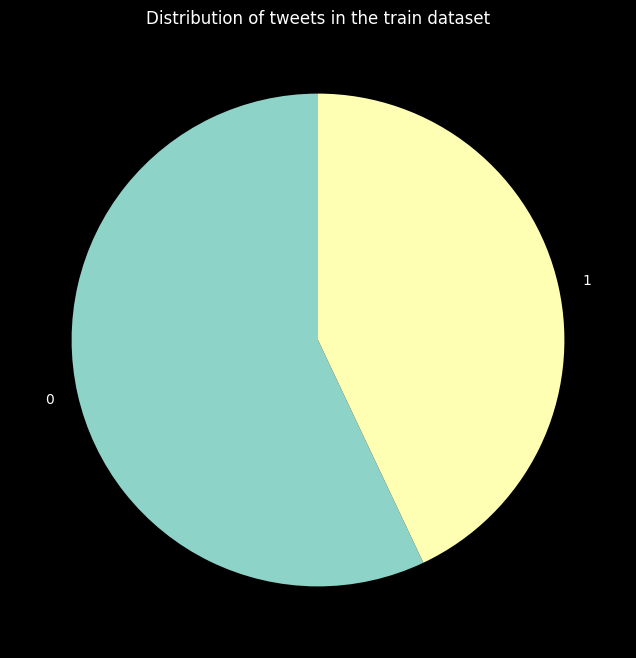

In [ ]:

value_counts = df.target.value_counts()

plt.style.use('dark_background')
plt.figure(figsize=(8,8))
plt.pie(value_counts, labels= value_counts.index, startangle=90)
plt.title("Distribution of tweets in the train dataset")
plt.show()

## For the data preprocessing I will perform some simple steps:
1. Remove the punctuation, text related to url, special characters, make the text lowercase
2. Remove stopwords (words that are very common in texts, but that don't have a significant meaning on their own)
3. Lemmatize the words. This will merge those words that are similar in meaning like (i.e. the word "cats" and the word "cat")
4. Tokenize the text. The words and certain other signs get converted to tokens that can be used in i.e. machine learning
5. Make sequences of the tokens. These convert the tokenize sentences into sequences (arrays)
6. Pad the sequences so all of them have the same size (this simplifies a lot, since the input values for the model have always the same shape).
7. Split the training dataset into train and validation sets

Before going forward with the vectorization of the text, I will clean the text and remove stop words

In [ ]:
# Taking this def from https://www.kaggle.com/tanulsingh077
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df.text = df.text.apply(lambda x: clean_text(x))

In [ ]:
print(df.text.head())

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

def filter_words(text):
  filtered_words = [ word for word in text.split(' ') if word not in stopwords.words('english')]
  return filtered_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_words(list_of_words):
  lemmatized_words = [ lemmatizer.lemmatize(word) for word in list_of_words]
  return lemmatized_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def clean_words(text):
  filtered_text = filter_words(text)
  lemmatized_text = lemmatize_words(filtered_text)
  return ' '.join(lemmatized_text)

In [ ]:
df['clean_text'] = df['text'].apply(lambda x: clean_words(x))

In [ ]:
print(df['clean_text'].head(5))

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3     people receive wildfire evacuation order cali...
4    got sent photo ruby alaska smoke wildfire pour...
Name: clean_text, dtype: object


In [ ]:
# This function is part of my own previous delivery in DTSA 5010. https://colab.research.google.com/drive/1Gxp8SQomP5er2ttXt5ZlBs8SMGjqiAnD#scrollTo=lZPV1dzzInJH
counter = Counter()
longest_text = 0
for sentence in df['clean_text']:
  words = word_tokenize(sentence)
  words = [word for word in words]
  sentence_size = len(words)
  if (sentence_size > longest_text):
    longest_text = sentence_size
  counter.update(words)

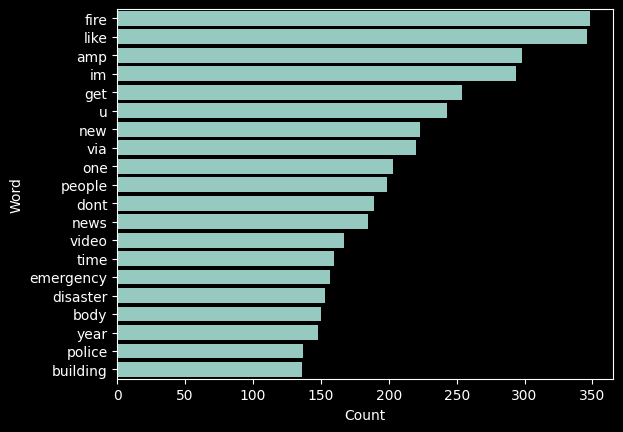

Longest tweet:  23


In [ ]:
# I take a look at the most common words in the cleaned text just to make sure they are as expected
most_common = counter.most_common(20)
words= []
number_words = []
df_frequency = pd.DataFrame(most_common, columns=['Word', 'Count'])
sns.barplot(data=df_frequency, x="Count", y="Word", orient = 'h', errorbar=None)
plt.style.use("dark_background")
plt.show()
print("Longest tweet: ", longest_text)

In [ ]:
max_nr_words = 5000
tokenizer = Tokenizer(num_words=max_nr_words)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

In [ ]:
padded_sequences = pad_sequences(sequences, longest_text)

## Splitting the DataFrame in train and validation data

In [ ]:
X = padded_sequences
y = df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print("Size training sample: ",  X_train.shape)
print("Size validation sample: ", X_val.shape)

Size training sample:  (6090, 23)
Size validation sample:  (1523, 23)


## Model Architecture
I am using two models with similar architecture, the only difference is that one uses a LSTM layer and the other a GRU layer.

The models are like this:
Embedding -> Dropout -> LSTM (or GRU) -> Dropout -> Dense (activation: sigmoid)

Embedding was a bit difficult to understand, but I found an explanation here: https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce

### I just made a simple model with some common values just to see how it worked

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_nr_words, 16, input_length=longest_text))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
lstm_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
191/191 [==============================] - 17s 56ms/step - loss: 0.5805 - accuracy: 0.6938 - val_loss: 0.4572 - val_accuracy: 0.7925
Epoch 2/5
191/191 [==============================] - 3s 18ms/step - loss: 0.4053 - accuracy: 0.8248 - val_loss: 0.4492 - val_accuracy: 0.7971
Epoch 3/5
191/191 [==============================] - 2s 11ms/step - loss: 0.3551 - accuracy: 0.8494 - val_loss: 0.4688 - val_accuracy: 0.7899
Epoch 4/5
191/191 [==============================] - 2s 8ms/step - loss: 0.3302 - accuracy: 0.8591 - val_loss: 0.5001 - val_accuracy: 0.7866
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.3118 - accuracy: 0.8681 - val_loss: 0.5134 - val_accuracy: 0.7695


### I decided to use Keras Tuner to find the best parameters for embedding, dropouts, lstm units and the learning rates

In [ ]:
# Using Keras Tuner to improve this simple model

def model_builder(hp):
  model = Sequential()
  model.add(Embedding(max_nr_words, hp.Int('embedded_units', min_value=4, max_value=24, step=4), input_length=longest_text))
  model.add(Dropout(hp.Float('drop_out_1', min_value=0.1, max_value=0.4, step=0.1)))
  model.add(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False))
  model.add(Dropout(hp.Float('drop_out_2', min_value=0.1, max_value=0.4, step=0.1)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer= Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='binary_crossentropy', metrics='accuracy')
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/models',
                     project_name='disaster_tweet')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.1, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 45s]
val_accuracy: 0.7931034564971924

Best val_accuracy So Far: 0.8160919547080994
Total elapsed time: 00h 10m 09s


In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - embedded_units: {best_hps.get('embedded_units')}")
print(f" - drop_out_1: {best_hps.get('drop_out_1')}")
print(f" - lstm_units: {best_hps.get('lstm_units')}")
print(f" - drop_out_2: {best_hps.get('drop_out_2')}")
print(f" - learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - embedded_units: 8
 - drop_out_1: 0.30000000000000004
 - lstm_units: 128
 - drop_out_2: 0.2
 - learning_rate: 0.001


In [ ]:
# Construct a model with the optimized hyperparameters (I did decided to adjust up the number of epochs and reduce the learning rate in an attemp to make the model training more stable)
lstm_model_best = Sequential()
lstm_model_best.add(Embedding(max_nr_words, 8, input_length=longest_text))
lstm_model_best.add(Dropout(0.3))
lstm_model_best.add(LSTM(128, return_sequences=False))
lstm_model_best.add(Dropout(0.2))
lstm_model_best.add(Dense(1, activation='sigmoid'))
lstm_model_best.compile(loss= 'binary_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics = ['accuracy'])

history = lstm_model_best.fit(X_train, y_train, epochs=9, validation_data=(X_val, y_val))

Epoch 1/9
191/191 [==============================] - 10s 43ms/step - loss: 0.6836 - accuracy: 0.5681 - val_loss: 0.6772 - val_accuracy: 0.5739
Epoch 2/9
191/191 [==============================] - 2s 12ms/step - loss: 0.6736 - accuracy: 0.5695 - val_loss: 0.6639 - val_accuracy: 0.5739
Epoch 3/9
191/191 [==============================] - 2s 10ms/step - loss: 0.6500 - accuracy: 0.6327 - val_loss: 0.6262 - val_accuracy: 0.6737
Epoch 4/9
191/191 [==============================] - 2s 10ms/step - loss: 0.5995 - accuracy: 0.7034 - val_loss: 0.5640 - val_accuracy: 0.7308
Epoch 5/9
191/191 [==============================] - 2s 10ms/step - loss: 0.5310 - accuracy: 0.7529 - val_loss: 0.5089 - val_accuracy: 0.7695
Epoch 6/9
191/191 [==============================] - 1s 7ms/step - loss: 0.4667 - accuracy: 0.7877 - val_loss: 0.4754 - val_accuracy: 0.7899
Epoch 7/9
191/191 [==============================] - 2s 8ms/step - loss: 0.4210 - accuracy: 0.8143 - val_loss: 0.4889 - val_accuracy: 0.7689
Epoch 8

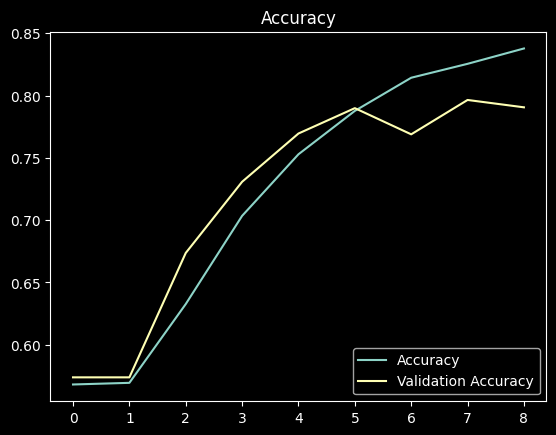

In [ ]:
# Visualizing accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"],loc="lower right")
plt.show()

### NB: I should have run hyperparameter tuning for the GRU model but for the sake of time, I used the same that the tuner found for the LSTM model

In [ ]:
# Construct a model with the optimized hyperparameters
gru_model = Sequential()
gru_model.add(Embedding(max_nr_words, 20, input_length=longest_text))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(128))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(loss= 'binary_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics = ['accuracy'])

history_gru = gru_model.fit(X_train, y_train, epochs=6, validation_data=(X_val, y_val))

Epoch 1/6
191/191 [==============================] - 9s 39ms/step - loss: 0.6834 - accuracy: 0.5645 - val_loss: 0.6727 - val_accuracy: 0.5739
Epoch 2/6
191/191 [==============================] - 3s 16ms/step - loss: 0.6612 - accuracy: 0.5864 - val_loss: 0.6388 - val_accuracy: 0.6487
Epoch 3/6
191/191 [==============================] - 2s 8ms/step - loss: 0.5989 - accuracy: 0.7243 - val_loss: 0.5596 - val_accuracy: 0.7301
Epoch 4/6
191/191 [==============================] - 2s 11ms/step - loss: 0.4816 - accuracy: 0.7829 - val_loss: 0.4667 - val_accuracy: 0.7840
Epoch 5/6
191/191 [==============================] - 1s 7ms/step - loss: 0.4000 - accuracy: 0.8248 - val_loss: 0.4516 - val_accuracy: 0.7951
Epoch 6/6
191/191 [==============================] - 1s 7ms/step - loss: 0.3666 - accuracy: 0.8409 - val_loss: 0.4476 - val_accuracy: 0.7997


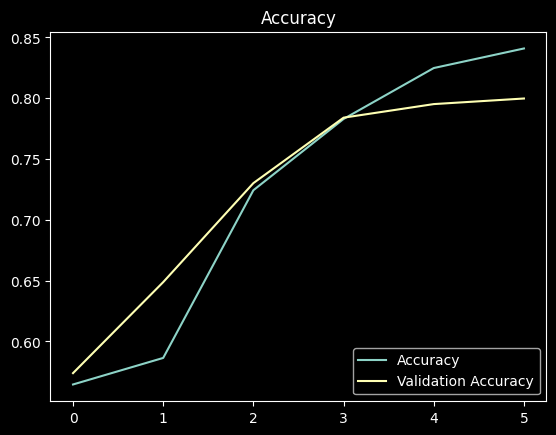

In [ ]:
# Visualizing accuracy vs epochs
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"],loc="lower right")
plt.show()

In [ ]:
y_pred_lstm = lstm_model_best.predict(X_val)
y_pred_gru = gru_model.predict(X_val)

48/48 [==============================] - 1s 6ms/step


In [ ]:

y_val_array = y_val.to_numpy()

y_pred_lstm = np.where(y_pred_lstm < 0.5, 0, 1)
y_pred_gru = np.where(y_pred_gru < 0.5, 0, 1)

y_pred_lstm_squeezed = np.squeeze(y_pred_lstm)
y_pred_gru_squeezed = np.squeeze(y_pred_gru)

confusion_matrix_lstm = metrics.confusion_matrix(y_val_array, y_pred_lstm_squeezed)
confusion_matrix_gru = metrics.confusion_matrix(y_val_array, y_pred_gru_squeezed)

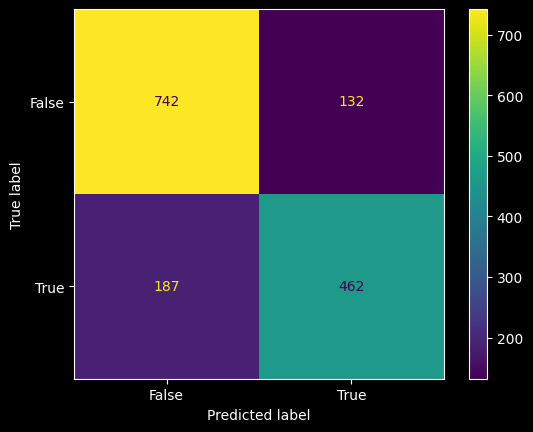

In [ ]:
display_lstm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_lstm, display_labels = [False, True])
display_lstm.plot()
plt.show()

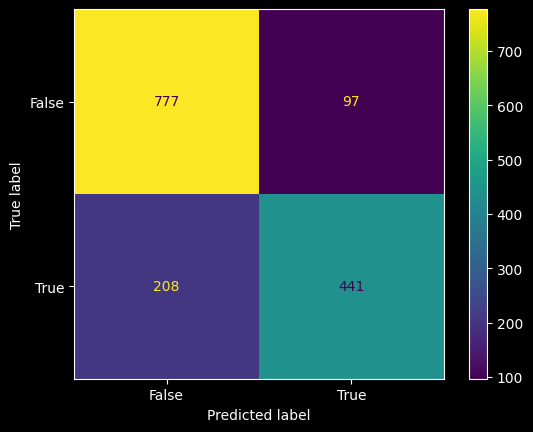

In [ ]:
display_lstm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_gru, display_labels = [False, True])
display_lstm.plot()
plt.show()

## Result and analysis:
1. The models were trained with few epochs. It was easy to see that the models have a clear tendency for overfitting. I tried to decrease the learning rate so the model would be able to learn the generalities of the texts, and avoiding overfitting.
2. The GRU model needed less training and gave better results. From the confusion matrix I saw that it was better to classify tweets that are NOT related to real disasters. Since these tweets are a slight majority, the model performed better.
3. I trained the models several times and found that they are a little bit sensitive to initial conditions. Validation accuracy could go from 0.77 to 0.81.

In [ ]:
# Predict from test
df_test = pd.read_csv('/content/dataset/test.csv')
df_test.text = df_test.text.apply(lambda x: clean_text(x))
df_test['clean_text'] = df_test['text'].apply(lambda x: clean_words(x))


In [ ]:
# Make sequences from Tokenizer
sequences_test = tokenizer.texts_to_sequences(df_test['clean_text'])
padded_sequences_test = pad_sequences(sequences_test, longest_text)
X_test = padded_sequences_test
y_test_lstm = lstm_model_best.predict(X_test)
y_test_gru = gru_model.predict(X_test)

y_test_lstm = np.where(y_test_lstm < 0.5, 0, 1)
y_test_gru = np.where(y_test_gru < 0.5, 0, 1)

#y_pred_lstm_squeezed = np.squeeze(y_pred_lstm)
#y_pred_gru_squeezed = np.squeeze(y_pred_gru)

102/102 [==============================] - 0s 2ms/step


In [ ]:
test_lstm = df_test.copy()
test_gru = df_test.copy()

test_lstm['target'] = y_test_lstm
test_gru['target'] = y_test_gru

In [ ]:
test_lstm.drop(["location", "keyword", "text", "clean_text"], axis=1, inplace=True)
test_gru.drop(["location", "keyword", "text", "clean_text"], axis=1, inplace=True)



In [ ]:
# Export the dataframe to a csv file and download the resulting file
test_lstm.to_csv("submission_lstm.csv", index=False)
test_gru.to_csv("submission_gru.csv", index=False)
files.download("/content/submission_lstm.csv")
files.download("/content/submission_gru.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusions:
1. This assignment was very straight forward and gave a good initial exposure to the problems related to NLP (natural language processing).
2. I have several improvements that I could have done in the data preprocessing: try a TweetTokenizer, try to use word embedding to give extra information about word similarity, replace some of the abreviations/mispellings from the most common words i.e. im to I am or u to you
3. Another possible improvement could be balancing the labels in the training and validation datasets
4. Use out of vocabulary (OOV) in the tokenizer.
5. The models were very simple and very prone to overfitting
6. The GRU model was faster to train and made better predictions


### Some references:
https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/

https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

https://www.w3schools.com/python/python_ml_confusion_matrix.asp

https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences